# Landau Theory of First Order Phase Transitions

In [1]:
import numpy as np
import numpy.linalg as npla

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from ipywidgets import widgets, interact, interactive

In [2]:
# # Set plot resolution
# mpl.rcParams['figure.dpi']= 300

## Landau Expansion (up to sixth order)

We can express the energy potential versus mean-field magnetization by performing a Taylor expansion:

$$ f(m, T) = f_0 (T) + am^2 + bm^4 + cm^6 + hm$$

A simple example of temperature dependence: let $a = \alpha (T - T_C)$, and $f_0 = - c_{v0} T^2$, where $T_C$ is the critical temperature.

*Based on (time-reversal) symmetry*: Only even powers allowed in the expansion.

In [3]:
def get_polys(f0, a, b, c, h):
    
    if c != 0.0:
        p_energy = [1/6 * c, 0.0, 1/4 * b, 0.0, 1/2 * a, h, f0];
    else:
        p_energy = [1/4 * b, 0.0, 1/2 * a, h, f0];
    p_deriv = np.polyder(p_energy);
    
    pn_deriv = p_deriv / p_deriv[0]
    #pn_deriv = p_deriv
    roots = np.roots(pn_deriv)
    
    return p_energy, p_deriv, pn_deriv, roots

def get_landau_poly(cv0, a, b, c, h, T, Tc):
    
    f0 = - 0.5 * cv0 * T**2
    ap = a * (T-Tc)
    
    p_energy, p_deriv, pn_deriv, roots = get_polys(f0, ap, b, c, h)
    
    return p_energy, p_deriv, pn_deriv, roots

def calculate_entropy(m, cv0, a, b, c, h, T, Tc):
    
    s = cv0 * T - a * m**2
    
    return s
    
def landau_plot(p_energy, p_deriv, roots, m_lims=()):
    
    nplt = 100 
    if m_lims:
        mv = np.linspace(m_lims[0], m_lims[1], nplt)
    else:
        mv = np.linspace(
            1.2*np.min(np.real(roots)), 
            1.2*np.max(np.real(roots)), nplt)
    
    energy = np.polyval(p_energy, mv)
    deriv = np.polyval(p_deriv, mv)
    
    plt.figure(100)
    
    plt.plot(mv, energy, linewidth=2);
    #plt.plot(mv, deriv, linewidth=2);
    plt.xlabel('$m$')
    plt.ylabel('$f(m)$')
    plt.title('Landau Free Energy')
    plt.show();

def landau_plot_A(cv0, a, b, c, h, T, Tc):
        
    p_energy, p_deriv, pn_deriv, roots = get_landau_poly(cv0, a, b, c, h, T, Tc)
    _, _, _, rb = get_landau_poly(cv0, a, b, c, h, 0.0, Tc)
    
    m_lims = (1.2*np.min(np.real(rb)), 1.2*np.max(np.real(rb)))
    #m_lims = None
    
    landau_plot(p_energy, p_deriv, roots, m_lims)

In [4]:
Tc = 1.0
cv0, a, b, c, h = 0.0, 1.0, -2.5, 1.0, 0.0

(p_energy, p_deriv, pn_deriv, roots) = get_polys(0.0, a, b, c, h)
pord = len(roots)

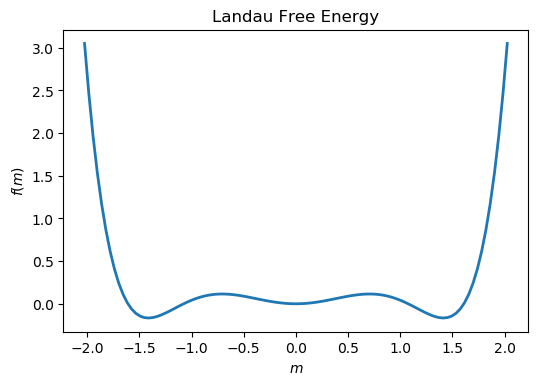

In [5]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 100

T = 2.0

landau_plot_A(cv0, a, b, c, h, T, Tc)

In [6]:
#%matplotlib widget
#%matplotlib ipympl
%matplotlib inline
mpl.rcParams['figure.dpi']= 100

interactive_plot = interactive(
    landau_plot_A,
    cv0=(0.0, 1.0, 0.1), a=(0.0, 2.0, 0.1), b=(-3.0, 1.0, 0.1), c=(0.0, 1.0, 0.1),
    h=(-1.0, 1.0, 0.1), T=(0.0, 3.0, 0.1), Tc=(0.5, 1.5, 0.5)
)

output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='cv0', max=1.0), FloatSlider(value=1.0, description='…

## Hysteresis of the Sixth Order potential
### Time Dependent Kinetic Response

The hysteresis effects are important to account for in magnetocaloric materials:
* First order transitions have the following tradeoff: There is a **large latent heat associated with the phase transition**, which results in **pronounced hysteresis effects** that can reduce cooling efficiency with rapid cycling.

$$ f(m, T) = f_0 (T) + a(T - T_C)m^2 + bm^4 + cm^6 + hm$$

We can define the following dissipative time-evolution equation, where $L$ is a kinetic constant:

$$ \frac{\partial m}{\partial t} = - L \frac{\delta F}{\delta m} = -L \frac{\partial f}{\partial m} $$

In [7]:
from td_landau_solver import *

In [8]:
def relax_landau(
    m_init, m0, L, t_end,
    cv0, a, b, c, h, T, Tc,
    tol=1.0e-10):
    
    (p_energy, p_deriv, pn_deriv, roots) = get_landau_poly(cv0, a, b, c, h, T, Tc)
    pord = len(roots)
    
    m = m_init
    try:
        exps = get_exps_lhs(roots, pord)

        # Kinetic
        alpha = p_deriv[0] * L

        m = zero_finder_sv (m_init, m0, roots, exps, t_end, alpha, tol=tol)
    except:
        # print('Found singularity')
        a = None
    
    return m

In [9]:
Tc = 1.0
cv0, a, b, c, h = 0.0, 1.0, -2.5, 1.0, -0.5

T = 2.0

(p_energy, p_deriv, pn_deriv, roots) = get_landau_poly(cv0, a, b, c, h, T, Tc)
pord = len(roots)

# Kinetic
L = 1.0
alpha = p_deriv[0] * L

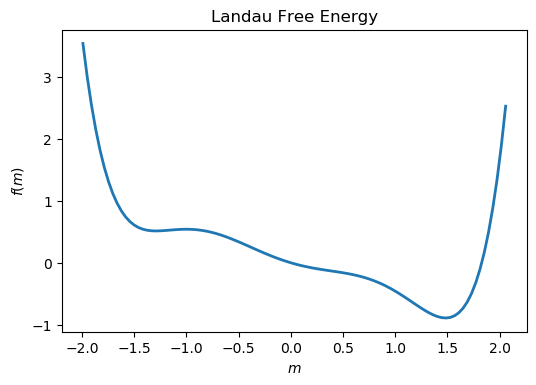

In [10]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 100

T = 2.0
landau_plot_A(cv0, a, b, c, h, T, Tc)

In [11]:
# x = newton_raphson_poly(p_deriv, 1.0)
# print(x)

In [12]:
# Initial magnetization
m0 = - 0.8

tv = np.linspace(0.0, 8.0, 30);
mv = np.zeros(tv.shape);

tol = 1.0e-10

exps = get_exps_lhs(roots, pord)

m = m0
for i in range(len(tv)):
    m = zero_finder_sv (m, m0, roots, exps, tv[i], alpha, tol=tol)
    mv[i] = m

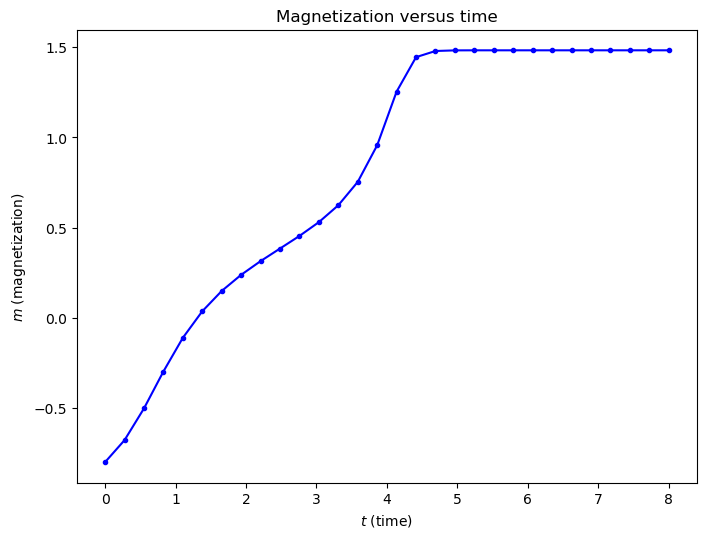

In [13]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 100

plt.figure(figsize=[8,6]);
plt.plot(tv, mv, 'b.-');
plt.ylabel('$m$ (magnetization)');
plt.xlabel('$t$ (time)');
plt.title('Magnetization versus time')
plt.show();

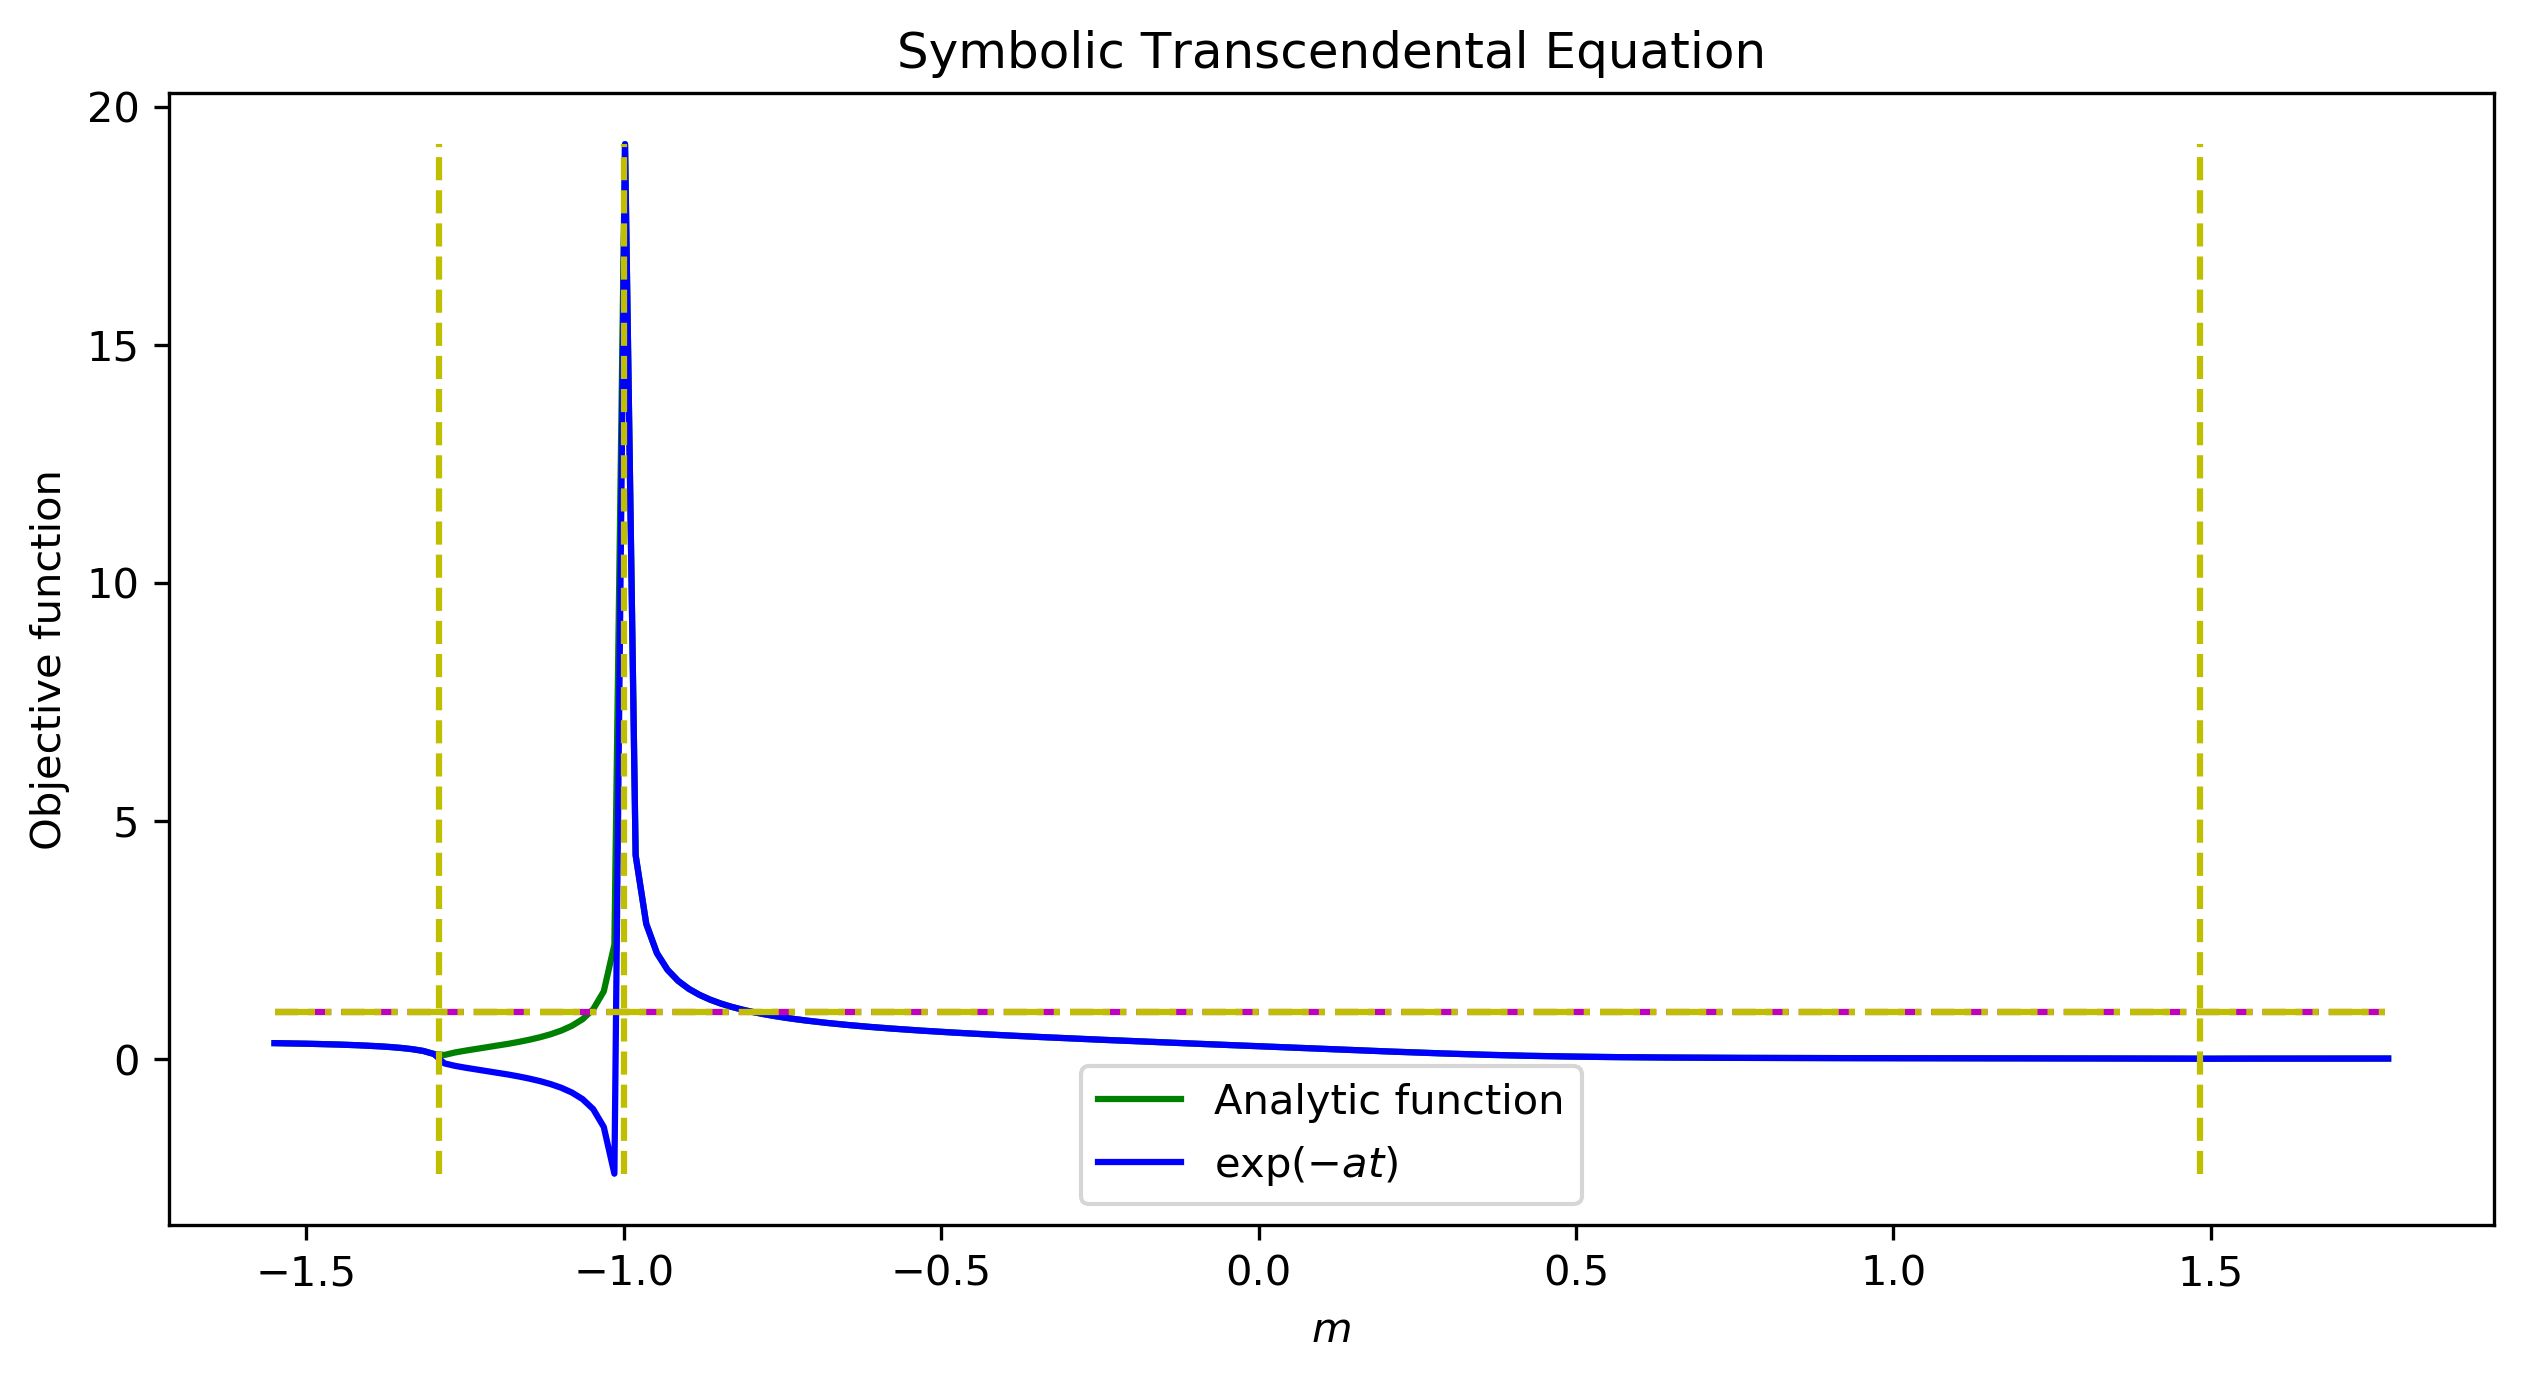

In [14]:
# Show Transcendental Equation
t = 0.0
m = np.linspace(
            1.2*np.min(np.real(roots)), 
            1.2*np.max(np.real(roots)), 200)
y = (sv_lhs (m, m0, roots, exps))

%matplotlib inline
mpl.rcParams['figure.dpi']= 300

plt.figure(figsize=[10,5]);
plt.plot(m, np.abs(y), 'g-')
#plt.plot(m, np.imag(y), 'r-')
plt.plot(m, np.real(y), 'b-')

plt.plot(m, np.exp(-alpha*t) + 0.0*m, 'm--')
#plt.plot(m, -alpha*t + 0.0*m, 'm--')
plt.plot(m, 1.0 + 0.0*m, 'y-.')

for r in roots:
    if np.abs(np.imag(r)) < 1e-12:
        plt.plot(np.real(r) + 0.0*m, 
                 np.linspace(np.min(np.real(y)), np.max(np.real(y)), len(m)), 'y--')

plt.xlabel('$m$')
plt.ylabel('Objective function')
plt.title('Symbolic Transcendental Equation')
plt.legend(['Analytic function', '$\exp (-a t)$'])
plt.show()

plt.show()

### <center> Newton-Raphson Method </center>
![FractalUrl](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/NewtonIteration_Ani.gif/300px-NewtonIteration_Ani.gif "NR Method")

In [39]:
# Critical temperature
Tc = 1.0

# Relaxation time - kinetics dependent parameter 
t_end = 100.0

# Sixth order potential 
cv0, a, b, c, h = 0.5, 1.0, -2.5, 1.0, 0.0

# # Forth order potential
# cv0, a, b, c, h = 0.5, 1.0, 2.5, 0.0, 0.0

_, _, _, roots = get_landau_poly(cv0, a, b, c, h, 0.0, Tc)

temps = np.linspace(0.0, 3.0, 100)
mv_a = 0.0 * temps
mv_b = 0.0 * temps

sv_a = 0.0 * temps
sv_b = 0.0 * temps

mp = 1.0e-4
m0 = np.max(np.real(roots))
m = m0

# Convergence tolerance
tol = 1.0e-9

#
T = temps[0]
m_init = m # + np.random.normal(0.0, mp, [1])[0]
m = relax_landau(
    m_init, m0, L, t_end,
    cv0, a, b, c, h, T, Tc,
    tol=tol)
m0 = m
#

# print('m0 = ', m0)

for i,temp in enumerate(temps):
    
    T = temp
    
    # m_init = m
    m_init = m + np.random.normal(0.0, mp, [1])[0]
    # m_init = m + mp
    
    m = relax_landau(
        m_init, m0, L, t_end,
        cv0, a, b, c, h, T, Tc,
        tol=tol)
    
    mv_a[i] = m
    sv_a[i] = calculate_entropy(m, cv0, a, b, c, h, T, Tc)
    
    # print('m = ', m)
    
for i,temp in reversed(list(enumerate(temps))):
    
    T = temp
        
    # m_init = m
    m_init = m + np.random.normal(0.0, mp, [1])[0]
    # m_init = m - mp
    
    m = relax_landau(
        m_init, m0, L, t_end,
        cv0, a, b, c, h, T, Tc,
        tol=tol)
    
    mv_b[i] = m
    sv_b[i] = calculate_entropy(m, cv0, a, b, c, h, T, Tc)
    
    # print('m = ', m)

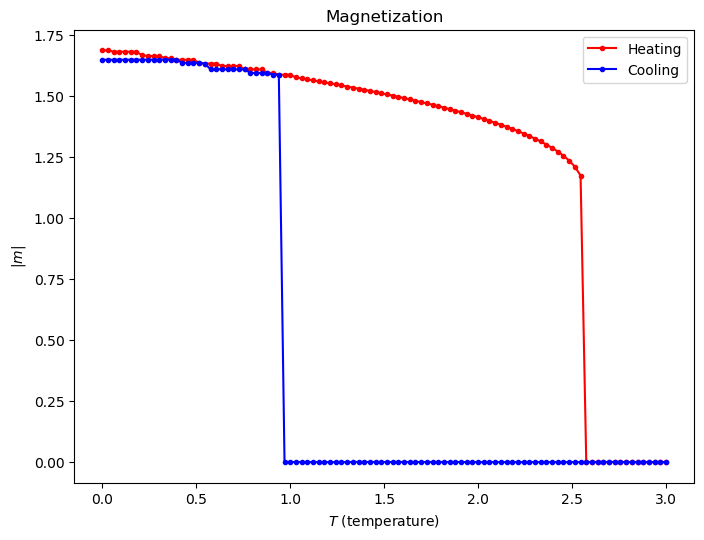

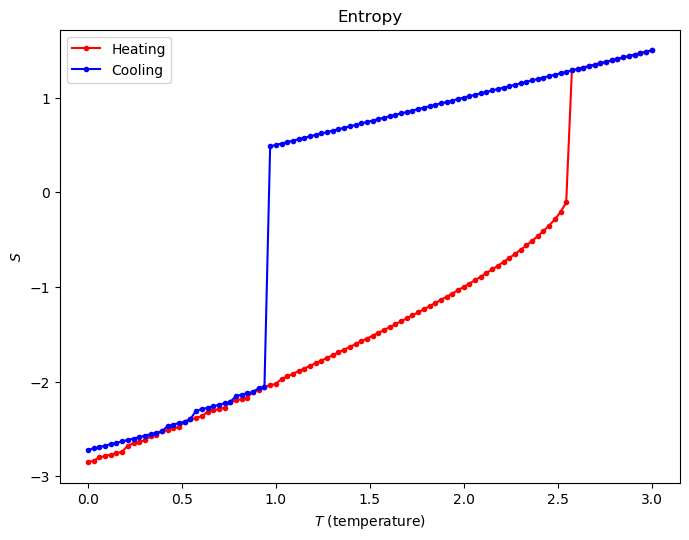

In [40]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 100

plt.figure(figsize=[8,6]);
plt.plot(temps, np.abs(mv_a), 'r.-');
plt.plot(temps, np.abs(mv_b), 'b.-');
plt.ylabel('$|m|$');
plt.xlabel('$T$ (temperature)');
plt.legend(['Heating', 'Cooling'])
plt.title('Magnetization')
plt.show();

plt.figure(figsize=[8,6]);
plt.plot(temps, sv_a, 'r.-');
plt.plot(temps, sv_b, 'b.-');
plt.ylabel('$S$');
plt.xlabel('$T$ (temperature)');
plt.legend(['Heating', 'Cooling'])
plt.title('Entropy')
plt.show();

## Next time: Renormalization Group Approach

The RG approach is ideal for examining critical behavior near to the phase transition.

### <center> Ising Model </center>
![IsingUrl](https://mrocklin.github.com/blog/images/ising.gif "Ising")

### *Fractals...*

### <center> Newton-Raphson Polynomial Root-Finding Fractal </center>
![FractalUrl](https://i.gifer.com/NPp7.gif "Root Finding Fractal")

### <center> Newton-Raphson Method </center>
![FractalUrl](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/NewtonIteration_Ani.gif/300px-NewtonIteration_Ani.gif "NR Method")